In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev

# Numeric machine learning model with RandomForestClassifier and LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

In [137]:
# Create a dataframe of the csv file
data = pd.read_csv("final_dataset.csv")

In [138]:
x = data[["price","overall rating","number sold","total review", "salary"]]
y = data["sentiment"]

print("x shape:", x.shape)

x shape: (5147, 5)


In [139]:
# Use standard scaler for logistic regression
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [140]:
# Another data split for the x data with no added polynomial features (this is for the tree based models)
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42
)

In [141]:
LR = LogisticRegression()
HGB = HistGradientBoostingClassifier()
RF = RandomForestClassifier()

In [142]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [143]:
def test_model(model):
    lst_accu_stratified = []
    for train_index, test_index in skf.split(x, y):
        if isinstance(model, LogisticRegression):
            x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
        else:
            x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        model.fit(x_train_fold, y_train_fold)
        lst_accu_stratified.append(model.score(x_test_fold, y_test_fold))
        
    print('List of possible accuracy:', lst_accu_stratified)
    print('\nMaximum Accuracy That can be obtained from this model is:',
        max(lst_accu_stratified))
    print('\nMinimum Accuracy:',
        min(lst_accu_stratified))
    print('\nOverall Accuracy:',
        mean(lst_accu_stratified))
    print('\nStandard Deviation is:', stdev(lst_accu_stratified))

In [144]:
# TESTING HIGHEST POSSIBLE ACCURACY (not yet training the model)
# 1. Logistic Regression
print("Logistic Regression Results:")
test_model(LR)

# 2. Random Forest Classifier
print("\nRandom Forest Classifier Results:")
test_model(RF)

# 3. HistGradientBoostingClassifier
print("\nHistGradientBoostingClassifier Results:")
test_model(HGB)

Logistic Regression Results:
List of possible accuracy: [0.5766990291262136, 0.6407766990291263, 0.6233009708737864, 0.6097087378640776, 0.6038834951456311, 0.6213592233009708, 0.5980582524271845, 0.6070038910505836, 0.632295719844358, 0.5914396887159533]

Maximum Accuracy That can be obtained from this model is: 0.6407766990291263

Minimum Accuracy: 0.5766990291262136

Overall Accuracy: 0.6104525707377886

Standard Deviation is: 0.019409969343554604

Random Forest Classifier Results:
List of possible accuracy: [0.6737864077669903, 0.6718446601941748, 0.6990291262135923, 0.6970873786407767, 0.6737864077669903, 0.6970873786407767, 0.6776699029126214, 0.6731517509727627, 0.7159533073929961, 0.6439688715953308]

Maximum Accuracy That can be obtained from this model is: 0.7159533073929961

Minimum Accuracy: 0.6439688715953308

Overall Accuracy: 0.6823365192097012

Standard Deviation is: 0.02021662918357546

HistGradientBoostingClassifier Results:
List of possible accuracy: [0.6427184466019

TRAINING THE MACHINE LEARNING MODELS

In [145]:
# 1. Logistic Regression
LR.fit(scaler.transform(x_train), y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [146]:
# 2. Random Forest Classifier
RF.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [147]:
# 3. HistGradientBoostingClassifier
HGB.fit(x_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,max_iter,100
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'
,monotonic_cst,None


In [148]:
# PREDICTIONS
pred_lr  = LR.predict(scaler.transform(x_test))
pred_rf  = RF.predict(x_test)
pred_hgb = HGB.predict(x_test)

print("LR final accuracy:", accuracy_score(y_test, pred_lr))
print("RF final accuracy:", accuracy_score(y_test, pred_rf))
print("HGB final accuracy:", accuracy_score(y_test, pred_hgb))

LR final accuracy: 0.6174757281553398
RF final accuracy: 0.6747572815533981
HGB final accuracy: 0.6631067961165048


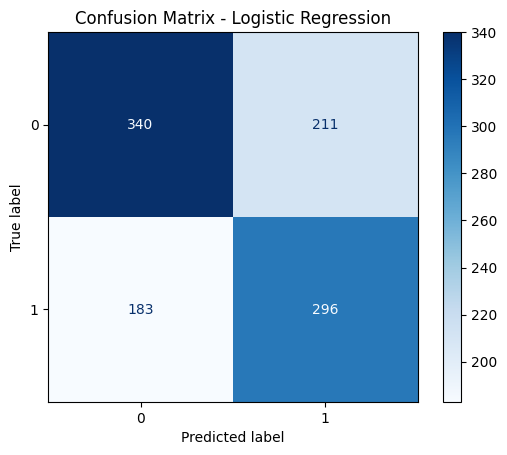

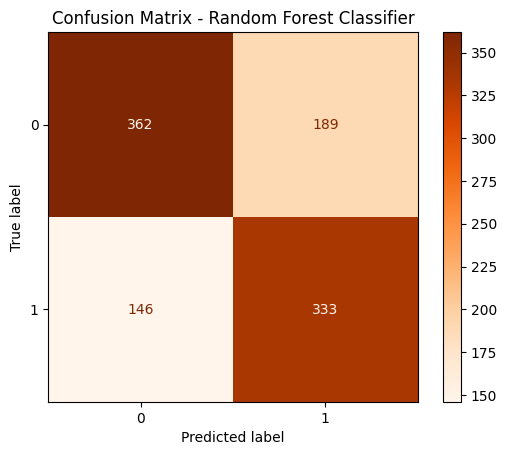

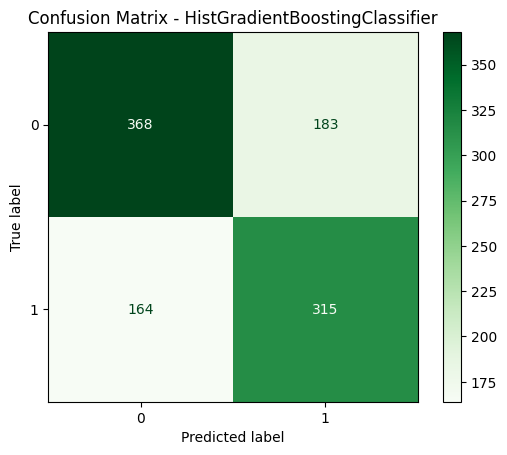

In [149]:
# CONFUSION MATRIX
# Logistic Regression confusion matrix
ConfusionMatrixDisplay.from_estimator(LR, scaler.transform(x_test), y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Random Forest Classifier confusion matrix
ConfusionMatrixDisplay.from_estimator(RF, x_test, y_test, cmap='Oranges')
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

# HistGradientBoostingClassifier confusion matrix
ConfusionMatrixDisplay.from_estimator(HGB, x_test, y_test, cmap='Greens')
plt.title("Confusion Matrix - HistGradientBoostingClassifier")
plt.show()

TUNING OUR BEST PERFORMING MACHINE LEARNING MODEL: Random Forest Classifier
(with a max accuracy score of 0.7029126213592233)

In [150]:
# Find the baseline accuracy of the Random Forest Classifier
rf_baseline = RandomForestClassifier(random_state=432)
rf_baseline.fit(x_train, y_train)

y_pred = rf_baseline.predict(x_test)
print("Random Forest Classifier Baseline Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest Classifier Baseline Accuracy: 0.6650485436893204
              precision    recall  f1-score   support

           0       0.71      0.64      0.67       551
           1       0.63      0.70      0.66       479

    accuracy                           0.67      1030
   macro avg       0.67      0.67      0.66      1030
weighted avg       0.67      0.67      0.67      1030



In [151]:
# Use randomized search CV to tune the Random Forest Classifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=RF,
    param_distributions=param_grid,
    n_iter=30,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(x_train, y_train)

print("Best Parameters:", rf_random.best_params_)
print("Best CV Accuracy:", rf_random.best_score_)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best CV Accuracy: 0.6803510127523034


In [152]:
rf_best = rf_random.best_estimator_
test_pred = rf_best.predict(x_test)
print("Test Accuracy:", accuracy_score(y_test, test_pred))

Test Accuracy: 0.6766990291262136


Although we already tuned this to the best settings, it is still not a good model accuracy, therefore we could see that we are still lacking with the features. Now it's time to add more features such as categorical features or even the 'customer review' (the comment from the customer in text form of that particular product). 

We proceed with vectorizing the text file to become numerical. Let's use OneHotEncoder for our categorical features, and using TF-IDF vectorizer for the customer review text (Interesting Note: Since tokopedia comments are in the Indonesian language we use the libarary Sastrawi in order to get the indonesian stop words to then be used by TF-IDF)! 

In [153]:
# Use this libary for combing the numerical features with the categorical features
from sklearn.compose import ColumnTransformer

# This one is for the categorical features = [category, region]
from sklearn.preprocessing import OneHotEncoder

# This one is for the purely text feature (all suppose to be unique text data) = customer review
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
# Get the indonesian stop words
stop_words_ind = StopWordRemoverFactory().get_stop_words()

from sklearn.pipeline import Pipeline

In [154]:
numerical_features = ["price", "overall rating", "number sold", "total review", "salary"]
categorical_features = ["category", "region"] 
text_features = "customer review"

In [155]:
X = data[numerical_features + categorical_features + [text_features]]

preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            max_features=5000,
            stop_words=stop_words_ind,
            ngram_range=(1,2),
            sublinear_tf=True
        ), text_features),
        
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        
        ("num", "passthrough", numerical_features)
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", rf_best)
])

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=432
)

model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print("Final Model with Text + Categorical Features Accuracy:",
      accuracy_score(Y_test, y_pred))

print(classification_report(Y_test, y_pred))

Final Model with Text + Categorical Features Accuracy: 0.9174757281553398
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       521
           1       0.92      0.91      0.92       509

    accuracy                           0.92      1030
   macro avg       0.92      0.92      0.92      1030
weighted avg       0.92      0.92      0.92      1030



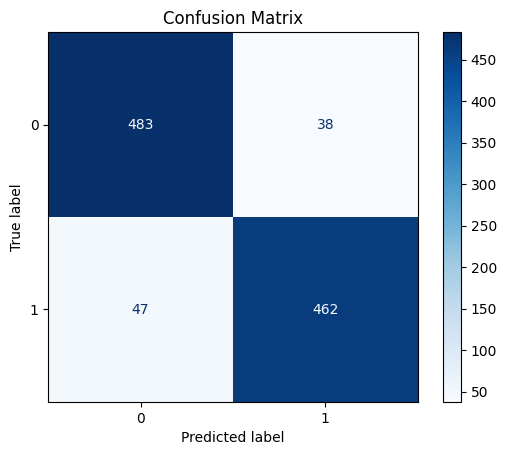

In [163]:
ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    Y_test,
    display_labels=model.named_steps["classifier"].classes_,
    cmap="Blues",
    xticks_rotation="horizontal"
)
plt.title("Confusion Matrix")
plt.show()


In [164]:
unique, counts = np.unique(y_pred, return_counts=True)
print("Prediction distribution:")
for u, c in zip(unique, counts):
    print(f"{u}: {c}")

Prediction distribution:
0: 530
1: 500


In [165]:
unique, counts = np.unique(Y_test, return_counts=True)
print("True label distribution:")
for u, c in zip(unique, counts):
    print(f"{u}: {c}")

True label distribution:
0: 521
1: 509
